# <center>Supplementary Information for</center>
## <center>__A Descriptor Is All You Need: Accurate Machine Learning of Nonadiabatic Coupling Vectors__</center>
### <center>Jakub Martinka<sup>1,2</sup>, Lina Zhang<sup>3</sup>, Yi-Fan Hou<sup>3</sup>, Mikolaj Martyka<sup>4</sup>, Jiří Pittner<sup>\*,1</sup>, Mario Barbatti<sup>\*,5,6</sup> and Pavlo O. Dral<sup>*,3,7,8</sup>

$^1$ J. Heyrovský Institute of Physical Chemistry, Academy of Sciences of the Czech Republic, v.v.i., Dolejškova 3, 18223 Prague 8, Czech Republic<br>
$^2$ Department of Physical and Macromolecular Chemistry, Faculty of Sciences, Charles University, Hlavova 8, 128 43 Prague 2, Czech Republic<br>
$^3$ State Key Laboratory of Physical Chemistry of Solid Surfaces, Department of Chemistry, College of Chemistry and Chemical Engineering, and Fujian Provincial Key Laboratory of Theoretical and Computational Chemistry, Xiamen University, Xiamen 361005, China<br>
$^4$ Faculty of Chemistry, University of Warsaw, Pasteura 1, Warsaw, 02-093, Poland<br>
$^5$ Aix Marseille University, CNRS, ICR, Marseille, France<br>
$^6$ Institut Universitaire de France, 75231 Paris, France<br>
$^7$ Institute of Physics, Faculty of Physics, Astronomy,and Informatics, Nicolaus Copernicus University in Toruń, ul. Grudziądzka 5, 87-100 Toruń, Poland<br>
$^8$ Aitomistic, Shenzhen, China<br>
$^*$ Corresponding authors: jiri.pittner@jh-inst.cas.cz, mario.barbatti@univ-amu.fr, dral@xmu.edu.cn
___

Data used within this Jupyter Notebook are available from: https://github.com/JakubMartinka/Fulvene-ML-FSSH

Training and test sets, as well as models, are saved on FigShare: https://doi.org/10.6084/m9.figshare.28877672

Trajectories in H5MD format (exceeding 10 GB) can be provided upon request due to their size.


In [5]:
import numpy as np
import pandas as pd
import mlatom as ml
import csv

from prettytable import PrettyTable
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# Colors:
cg = '#1b9e77'
co = '#d95f02'
cp = '#7570b3'
cr = '#e7298a'
cdg = '#014D4E'

In [2]:
# Function to save figures
from pathlib import Path
IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=1200, bbox_inches="tight"):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, facecolor='white', transparent=False)

# Function for confidence interval
def mean_confidence_interval(p, N):
    return 1.96*np.sqrt(p * (1 - p) / N)

# Function to extract hopping points
def get_hop_geos(traj):
    nstates = len(traj.steps[0].molecule.electronic_states)
    local_hop_list = [[ [] for k in range(nstates)] for j in range(nstates)]
    for index, geom in enumerate(traj.steps):
        if index !=0:
            if geom.current_state != traj.steps[index-1].current_state:
                hop_to = int(geom.current_state)
                hop_from = int(traj.steps[index-1].current_state)
                traj.steps[index-1].molecule.hoptime = traj.steps[index-1].time
                local_hop_list[hop_from][hop_to].append(traj.steps[index-1].molecule)

    geoms = []
    for k in range(nstates):
        for j in range(nstates):
            if local_hop_list[k][j] != None:
                for hop_geom in local_hop_list[k][j]:
                    hop_geom.hop_from = k
                    hop_geom.hop_to = j
                    geoms.append(hop_geom)
    return geoms

## 1. Descriptor benchmark results
The benchmark of descriptors was done for all combinations of dE, RE, ddgrad, ndgrad, adgrad descriptors, on a three test sets:
- Test set 1: consists of 5000 randomly selected points from all trajectories
- Test set 2: contains 5000 randomly selected points, where Frobenius norm of NACs is larger than 5
- Test set 3: 6010 points from the first 10 trajectories

`benchmark_CASSCFlabeledSet.csv` contains RMSE/MAE/R2 for KRR models trained on CASSCF labeled phase-corrected data set containing 5950 points.

`benchmark_MSANIlabeledSet.csv` contains RMSE/MAE/R2 for KRR models trained on the above dataset, but energies and gradients were labeled by MS-ANI model (which was trained on augmented data set of 10950).

In [47]:
# Load CASSCF and MS-ANI+KRR data
benchmark_data = {
    'benchmark_CASSCFlabeledSet.csv': {},
    'benchmark_MSANIlabeledSet.csv': {},
}

digits = 5
for output_name in benchmark_data.keys():
    benchmark_data[output_name] = pd.read_csv(f'data/{output_name}')

    bm_table = PrettyTable(["Descriptor", "Test 1  RMSE (1/Å)", "Test 1 MAE (1/Å)", "Test 1 R2", "Test 2 RMSE (1/Å)", "Test 2 MAE (1/Å)", "Test 2 R2", "Test 3 RMSE (1/Å)", "Test 3 MAE (1/Å)", "Test 3 R2"])
    bm_table.title = f'Descriptor benchmark from {output_name}'
    for index, row in benchmark_data[output_name].iterrows():
        bm_table.add_row([row["Descriptor"],f'{row["TestSet1 RMSE"]:.{digits}f}',f'{row["TestSet1 MAE"]:.{digits}f}',f'{row["TestSet1 R2"]:.{digits}f}',f'{row["TestSet2 RMSE"]:.{digits}f}',f'{row["TestSet2 MAE"]:.{digits}f}',f'{row["TestSet2 R2"]:.{digits}f}',f'{row["TestSet3 RMSE"]:.{digits}f}',f'{row["TestSet3 MAE"]:.{digits}f}',f'{row["TestSet3 R2"]:.{digits}f}'])

    print(bm_table)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                               Descriptor benchmark from benchmark_CASSCFlabeledSet.csv                                                               |
+----------------------------+--------------------+------------------+-----------+-------------------+------------------+-----------+-------------------+------------------+-----------+
|         Descriptor         | Test 1  RMSE (1/Å) | Test 1 MAE (1/Å) | Test 1 R2 | Test 2 RMSE (1/Å) | Test 2 MAE (1/Å) | Test 2 R2 | Test 3 RMSE (1/Å) | Test 3 MAE (1/Å) | Test 3 R2 |
+----------------------------+--------------------+------------------+-----------+-------------------+------------------+-----------+-------------------+------------------+-----------+
|             RE             |      0.96422       |     0.12719      |  0.5

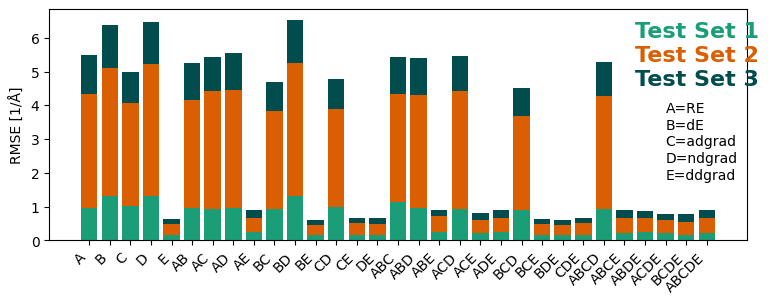

In [3]:
def encode_descriptor(row):
    encoding = {"RE": "A","dE": "B","adgrad": "C","ndgrad": "D","ddgrad": "E"}
    for key, value in encoding.items():
        row = row.replace(key, value)
        row = row.replace('_', '')
    return row

benchmark_data_casscf = pd.read_csv(f'data/benchmark_CASSCFlabeledSet.csv')
benchmark_data_casscf['Descriptor'] = benchmark_data_casscf['Descriptor'].apply(encode_descriptor)

fig, ax = plt.subplots(1, 1, figsize=(9, 3))
bottom = np.zeros(31)
colors = [cg, co, cdg]

i = 0
for d, d_count in benchmark_data_casscf.items():
    if 'RMSE' in d:
        p = ax.bar(benchmark_data_casscf['Descriptor'], d_count, 0.8, color=colors[i], label=d, bottom=bottom)
        bottom += d_count
        i += 1

ax.text(26.5, 6, r'Test Set 1', weight='bold', c=cg, fontsize=16)
ax.text(26.5, 5.3, r'Test Set 2', weight='bold', c=co, fontsize=16)
ax.text(26.5, 4.6, r'Test Set 3', weight='bold', c=cdg, fontsize=16)
ax.text(28, 3.8, r'A=RE', fontsize=10)
ax.text(28, 3.3, r'B=dE', fontsize=10)
ax.text(28, 2.8, r'C=adgrad', fontsize=10)
ax.text(28, 2.3, r'D=ndgrad', fontsize=10)
ax.text(28, 1.8, r'E=ddgrad', fontsize=10)
ax.set_ylabel('RMSE [1/Å]')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

#save_fig('desc_rmse')
plt.show()


## 2. Phase-correcting algorithm

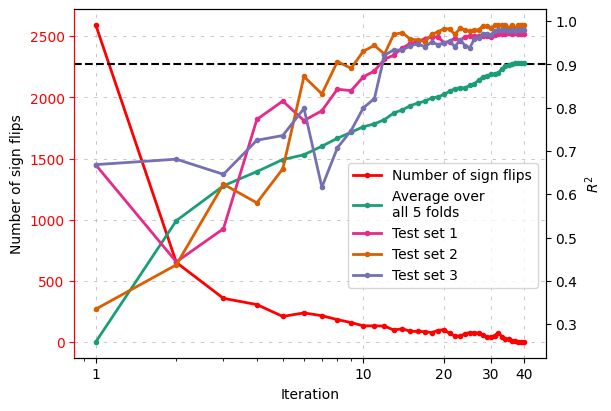

In [4]:
df = pd.read_csv('data/phasecorrection.csv')
df = df.groupby("iteration").agg({"flipped": "sum", "R2": "mean", "RMSE": "mean"}).reset_index()

df2 = pd.read_csv('data/phasecorrection_opthyper.csv')

fig, axs = plt.subplots(1, 1, figsize=(6, 4), layout="compressed")

axs.set_xlabel("Iteration")
axs.set_ylabel("Number of sign flips")
l1, = axs.plot(df['iteration'], df['flipped'], 'o-', lw=2, label='Number of sign flips', color="red", markersize=3)

axs2 = axs.twinx()
axs2.set_ylabel("$R^2$")
axs2.axhline(y=.9, c="black", linestyle='--')
l2, = axs2.plot(df['iteration'], df['R2'], 'o-', lw=2, label="Average over\nall 5 folds", c=cg, markersize=3) # Kfold test set:
l3, = axs2.plot(df2['iteration'], df2['R2_1'], 'o-', lw=2, label="Test set 1", c=cr, markersize=3) # Test set 1: 5000 randomly selected points
l4, = axs2.plot(df2['iteration'], df2['R2_2'], 'o-', lw=2, label="Test set 2", c=co, markersize=3) # Test set 2: 5000 points where Frobenius norm of NACs was larger than 5
l5, = axs2.plot(df2['iteration'], df2['R2_3'], 'o-', lw=2, label="Test set 3", c=cp, markersize=3) # Test set 3: 6010 points from first 10 trajectories

axs.set_xscale('log')
axs.set_xticks([1, 10, 20, 30, 40], ["1", "10", "20", "30", "40"])

lines = [l1, l2, l3, l4, l5]

axs.legend(lines, [l.get_label() for l in lines], loc=(0.58, 0.2))
axs.grid(linestyle = '--', dashes=(5, 9), linewidth = 0.5)

axs.tick_params(axis='y', colors="red")
axs2.spines['left'].set_color("red")

#save_fig('phase_correction', tight_layout=False)
plt.show()


## 3. Groups of hoppings
The margin of error is calculated as
\begin{equation*}
    \epsilon = 1.96\sqrt{\frac{p_i(1-p_i)}{N_{\text{traj}}}}
\end{equation*}

The mean torsional angle is calculated as 
\begin{equation*}
    \phi_{\text{C-CH}_2}=\frac{1}{4}\left( |\phi^{\text{cis}_1}_{\text{CC-CH}}| + |\phi^{\text{cis}_2}_{\text{CC-CH}}| + |180^\circ-\phi^{\text{trans}_1}_{\text{CC-CH}}| + |180^\circ-\phi^{\text{trans}_2}_{\text{CC-CH}}| \right)
\end{equation*}

In [ ]:
path = # path to the trajectories
output_name = 'hop_CASSCF_LZSH.csv'; Ntraj = 200
#output_name = 'hop_MSANI_LZSH.csv'; Ntraj = 1000
#output_name = 'hop_CASSCF.csv'; Ntraj = 200
#output_name = 'hop_MSANIKRR_ddgrad.csv'; Ntraj = 1000

C_CH2_lens = []; C_CH2_dihedral_Cis1 = []; C_CH2_dihedral_Cis2 = []; C_CH2_dihedral_trans1 = []; C_CH2_dihedral_trans2 = []; hop_times = []
for j in range(Ntraj):
    traj = ml.data.molecular_trajectory()
    if Ntraj == 200: # CASSCF
        traj.load(f"{path}TRAJ{j+1}/traj1.h5", format='h5md')
    if Ntraj == 1000: # MS-ANI + KRR
        traj.load(f"{path}TRAJ{j+1}/traj1.h5", format='h5md')
    hop_geoms = get_hop_geos(traj)
    for mol in hop_geoms:
        C_CH2_lens.append(mol.bond_length(0, 5))
        C_CH2_dihedral_Cis1.append(mol.dihedral_angle(2, 0, 5,10))
        C_CH2_dihedral_Cis2.append(mol.dihedral_angle(1, 0, 5,11))
        C_CH2_dihedral_trans1.append(mol.dihedral_angle(2, 0, 5,11))
        C_CH2_dihedral_trans2.append(mol.dihedral_angle(1, 0, 5,10))
        hop_times.append(mol.hoptime)

# Calculate hopping angle
hop_angle = []
for i in range(len(C_CH2_dihedral_Cis1)):
    hop_angle.append(0.25*(abs(C_CH2_dihedral_Cis1[i])+abs(C_CH2_dihedral_Cis2[i])+abs(180-abs(C_CH2_dihedral_trans1[i]))+abs(180-abs(C_CH2_dihedral_trans2[i]))))

with open(f'data/{output_name}', 'w', newline='') as ff:
    writer = csv.writer(ff)
    writer.writerow(['C_CH2_lens', 'hop_angle', 'hop_times'])
    writer.writerows(zip(C_CH2_lens, hop_angle, hop_times))

In [5]:
data = {
    'hop_CASSCF.csv': {},
    'hop_CASSCF_LZSH.csv': {},
    'hop_MSANIKRR_ddgrad.csv': {},
    'hop_MSANI_LZSH.csv': {},
}

for output_name in data.keys():
    data[output_name] = pd.read_csv(f'data/{output_name}')
hops = {
    'hop_CASSCF.csv': {},
    'hop_CASSCF_LZSH.csv': {},
    'hop_MSANIKRR_ddgrad.csv': {},
    'hop_MSANI_LZSH.csv': {},
}

# Count hopping occurence
for i, output_name in enumerate(data.keys()):
    hop_angle = data[output_name]['hop_angle'].tolist()
    C_CH2_lens = data[output_name]['C_CH2_lens'].tolist()
    # [Planar, Twisted-stretched, Twisted-shrunk, Total]
    hoppings = [0, 0, 0, len(hop_angle)]
    for i in range(len(hop_angle)):
        if hop_angle[i] < 30:
            hoppings[0] += 1
        else:
            if C_CH2_lens[i] > 1.55:
                hoppings[1] += 1
            else:
                hoppings[2] += 1
    hops[output_name] = hoppings

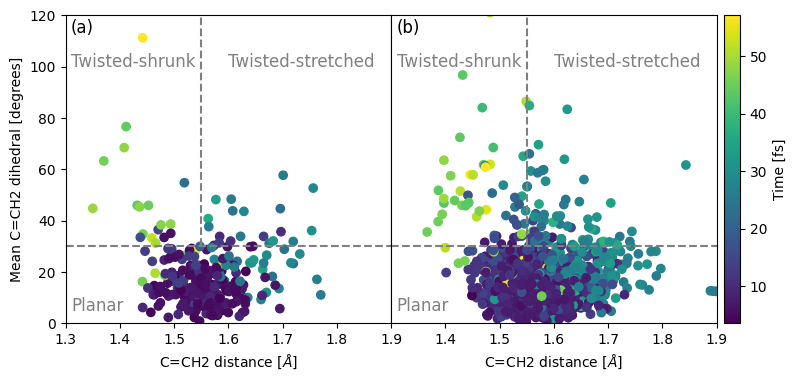

In [7]:
ylim = [0, 120]
xlim = [1.3, 1.9]
plot = ['(a)', '(b)']

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.subplots_adjust(wspace=0)

for i, output_name in enumerate(['hop_CASSCF.csv', 'hop_MSANIKRR_ddgrad.csv']):
    axs[i].axhline(y=30, color='grey', linestyle='--')
    axs[i].axvline(x=1.55, ymin=0.25, ymax=1, color='grey', linestyle='--')
    axs[i].text(1.31, 113, f'{plot[i]}', color='black', fontsize = 12)
    axs[i].text(1.31, 5, 'Planar', color='grey', fontsize = 12)
    axs[i].text(1.31, 100, 'Twisted-shrunk', color='grey', fontsize = 12)
    axs[i].text(1.6, 100, 'Twisted-stretched', color='grey', fontsize = 12)
    sc = axs[i].scatter(data[output_name]['C_CH2_lens'].tolist(), data[output_name]['hop_angle'].tolist(), c=data[output_name]['hop_times'].tolist())
    axs[i].set_xlabel("C=CH2 distance [$\AA$]")
    axs[i].set_ylabel("Mean C=CH2 dihedral [degrees]")
    axs[i].set_xlim(xlim)
    axs[i].set_ylim(ylim)
axs[1].set_xticks(axs[0].get_xticks()[1:])
axs[1].get_yaxis().set_visible(False)

cbar = fig.colorbar(sc, ax=axs, label='Time [fs]', pad=0.01)
#save_fig('hopping_channels', tight_layout=False)
plt.show()

## 4. Populations

In [9]:
pop = {'data/pop_CASSCF_LZSH.txt': 200,
       'data/pop_MSANI_LZSH.txt': 1000,
       'data/pop_COLE_COLNAC_200.txt': 200,
       'data/pop_COLE_MLNAC_200_ddgrad.txt': 200,
       'data/pop_MLE_MLNAC_wOrigMSANI_KRRonMSANI_ddgrad.txt': 1000,
       'data/pop_MLE_MLNAC_wOrigMSANI_KRRonMSANI_RE.txt': 1000,
       }
pop_names = list(pop.keys())

data_pop = {'time': []}
for i, name in enumerate(pop.keys()):
    data_pop[name] = {'S0': [], 'S1': [], 'S0pe': [], 'S0me': [], 'S1pe': [], 'S1me': []}
    with open(name, 'r') as ff:
        j = 0
        for line in ff.read().splitlines():
            values = list(map(float, line.split()))
            if i == 0:
                data_pop['time'].append(values[0])
            data_pop[name]['S0'].append(values[1])
            data_pop[name]['S1'].append(values[2])
            err = mean_confidence_interval(data_pop[name]['S1'][j], pop[name])
            data_pop[name]['S1pe'].append(data_pop[name]['S1'][j]+err)
            data_pop[name]['S1me'].append(data_pop[name]['S1'][j]-err)
            err = mean_confidence_interval(data_pop[name]['S0'][j], pop[name])
            data_pop[name]['S0pe'].append(data_pop[name]['S0'][j]+err)
            data_pop[name]['S0me'].append(data_pop[name]['S0'][j]-err)
            j += 1

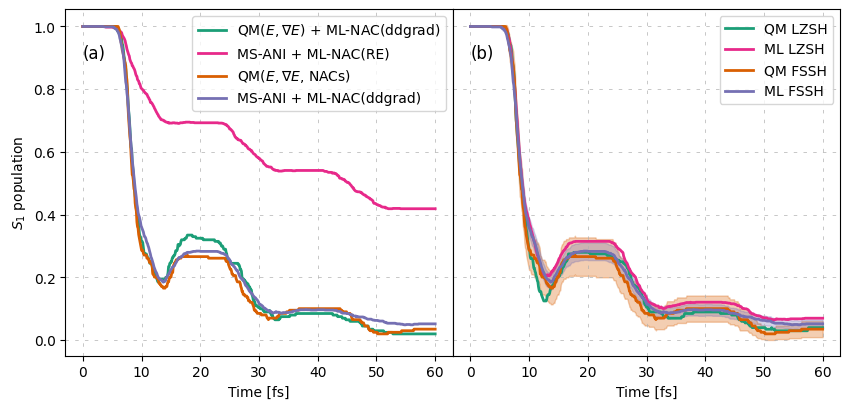

In [10]:
plot = ['(a)', '(b)']
state = 'S1'

fig, axs = plt.subplots(1, 2, figsize=(10, 4.5), sharey=True)
fig.subplots_adjust(wspace=0)

l0, = axs[0].plot(data_pop['time'], data_pop[pop_names[3]][state], c=cg, lw=2, label=r'QM($E,\nabla E$) + ML-NAC(ddgrad)')
l1, = axs[0].plot(data_pop['time'], data_pop[pop_names[5]][state], c=cr, lw=2, label='MS-ANI + ML-NAC(RE)')
l2, = axs[0].plot(data_pop['time'], data_pop[pop_names[2]][state], c=co, lw=2, label=r'QM($E,\nabla E$, NACs)')
l3, = axs[0].plot(data_pop['time'], data_pop[pop_names[4]][state], c=cp, lw=2, label='MS-ANI + ML-NAC(ddgrad)')

l4, = axs[1].plot(data_pop['time'], data_pop[pop_names[0]][state], c=cg, lw=2, label='QM LZSH')
l5, = axs[1].plot(data_pop['time'], data_pop[pop_names[1]][state], c=cr, lw=2, label='ML LZSH')
l6, = axs[1].plot(data_pop['time'], data_pop[pop_names[2]][state], c=co, lw=2, label='QM FSSH')
axs[1].fill_between(data_pop['time'], data_pop[pop_names[2]][state+"pe"], data_pop[pop_names[2]][state+"me"], color=co, alpha=0.3)
l7, = axs[1].plot(data_pop['time'], data_pop[pop_names[4]][state], c=cp, lw=2, label='ML FSSH')
axs[1].fill_between(data_pop['time'], data_pop[pop_names[4]][state+"pe"], data_pop[pop_names[4]][state+"me"], color=cp, alpha=0.3)

axs[0].set_ylabel('$S_1$ population')
for i in range(2):
    axs[i].set_xlabel('Time [fs]')
    axs[i].text(0, 0.9, f'{plot[i]}', color='black', fontsize = 12)
    axs[i].grid(linestyle = '--', dashes=(5, 9), linewidth = 0.5)

lines0 = [l0, l1, l2, l3]
axs[0].legend(lines0, [l.get_label() for l in lines0],loc="upper right")
lines1 = [l4, l5, l6, l7]
axs[1].legend(lines1, [l.get_label() for l in lines1],loc="upper right")
axs[1].tick_params(axis='y', which='both', length=0)

#save_fig('populations', tight_layout=False)
plt.show()


In [ ]:
table = PrettyTable(["Observable", "MS-ANI LZSH", "CASSCF LZSH", "MS-ANI+KRR FSSH", "CASSCF FSSH"])
table.add_rows(
    [ 
        ["Population at 20 fs (%)", f"{100*data_pop['data/pop_MSANI_LZSH.txt']['S1'][201]:.1f} +- {100*mean_confidence_interval(data_pop['data/pop_MSANI_LZSH.txt']['S1'][201], pop['data/pop_MSANI_LZSH.txt']):.1f}", f"{100*data_pop['data/pop_CASSCF_LZSH.txt']['S1'][201]:.1f} +- {100*mean_confidence_interval(data_pop['data/pop_CASSCF_LZSH.txt']['S1'][201], pop['data/pop_CASSCF_LZSH.txt']):.1f}", f"{100*data_pop['data/pop_MLE_MLNAC_wOrigMSANI_KRRonMSANI_ddgrad.txt']['S1'][201]:.1f} +- {100*mean_confidence_interval(data_pop['data/pop_MLE_MLNAC_wOrigMSANI_KRRonMSANI_ddgrad.txt']['S1'][201], pop['data/pop_MLE_MLNAC_wOrigMSANI_KRRonMSANI_ddgrad.txt']):.1f}", f"{100*data_pop['data/pop_COLE_COLNAC_200.txt']['S1'][201]:.1f} +- {100*mean_confidence_interval(data_pop['data/pop_COLE_COLNAC_200.txt']['S1'][201], pop['data/pop_COLE_COLNAC_200.txt']):.1f}"],
        ["Population at 40 fs (%)", f"{100*data_pop['data/pop_MSANI_LZSH.txt']['S1'][401]:.1f} +- {100*mean_confidence_interval(data_pop['data/pop_MSANI_LZSH.txt']['S1'][401], pop['data/pop_MSANI_LZSH.txt']):.1f}", f"{100*data_pop['data/pop_CASSCF_LZSH.txt']['S1'][401]:.1f} +- {100*mean_confidence_interval(data_pop['data/pop_CASSCF_LZSH.txt']['S1'][401], pop['data/pop_CASSCF_LZSH.txt']):.1f}", f"{100*data_pop['data/pop_MLE_MLNAC_wOrigMSANI_KRRonMSANI_ddgrad.txt']['S1'][401]:.1f} +- {100*mean_confidence_interval(data_pop['data/pop_MLE_MLNAC_wOrigMSANI_KRRonMSANI_ddgrad.txt']['S1'][401], pop['data/pop_MLE_MLNAC_wOrigMSANI_KRRonMSANI_ddgrad.txt']):.1f}", f"{100*data_pop['data/pop_COLE_COLNAC_200.txt']['S1'][401]:.1f} +- {100*mean_confidence_interval(data_pop['data/pop_COLE_COLNAC_200.txt']['S1'][401], pop['data/pop_COLE_COLNAC_200.txt']):.1f}"],
        ["Planar (%)", f"{100*hops['hop_MSANI_LZSH.csv'][0]/hops['hop_MSANI_LZSH.csv'][3]:.1f} +- {100*mean_confidence_interval(hops['hop_MSANI_LZSH.csv'][0]/hops['hop_MSANI_LZSH.csv'][3], hops['hop_MSANI_LZSH.csv'][3]):.1f}", f"{100*hops['hop_CASSCF_LZSH.csv'][0]/hops['hop_CASSCF_LZSH.csv'][3]:.1f} +- {100*mean_confidence_interval(hops['hop_CASSCF_LZSH.csv'][0]/hops['hop_CASSCF_LZSH.csv'][3], hops['hop_CASSCF_LZSH.csv'][3]):.1f}", f"{100*hops['hop_MSANIKRR_ddgrad.csv'][0]/hops['hop_MSANIKRR_ddgrad.csv'][3]:.1f} +- {100*mean_confidence_interval(hops['hop_MSANIKRR_ddgrad.csv'][0]/hops['hop_MSANIKRR_ddgrad.csv'][3], hops['hop_MSANIKRR_ddgrad.csv'][3]):.1f}", f"{100*hops['hop_CASSCF.csv'][0]/hops['hop_CASSCF.csv'][3]:.1f} +- {100*mean_confidence_interval(hops['hop_CASSCF.csv'][0]/hops['hop_CASSCF.csv'][3], hops['hop_CASSCF.csv'][3]):.1f}"],
        ["Twisted-stretched (%)", f"{100*hops['hop_MSANI_LZSH.csv'][1]/hops['hop_MSANI_LZSH.csv'][3]:.1f} +- {100*mean_confidence_interval(hops['hop_MSANI_LZSH.csv'][1]/hops['hop_MSANI_LZSH.csv'][3], hops['hop_MSANI_LZSH.csv'][3]):.1f}", f"{100*hops['hop_CASSCF_LZSH.csv'][1]/hops['hop_CASSCF_LZSH.csv'][3]:.1f} +- {100*mean_confidence_interval(hops['hop_CASSCF_LZSH.csv'][1]/hops['hop_CASSCF_LZSH.csv'][3], hops['hop_CASSCF_LZSH.csv'][3]):.1f}", f"{100*hops['hop_MSANIKRR_ddgrad.csv'][1]/hops['hop_MSANIKRR_ddgrad.csv'][3]:.1f} +- {100*mean_confidence_interval(hops['hop_MSANIKRR_ddgrad.csv'][1]/hops['hop_MSANIKRR_ddgrad.csv'][3], hops['hop_MSANIKRR_ddgrad.csv'][3]):.1f}", f"{100*hops['hop_CASSCF.csv'][1]/hops['hop_CASSCF.csv'][3]:.1f} +- {100*mean_confidence_interval(hops['hop_CASSCF.csv'][1]/hops['hop_CASSCF.csv'][3], hops['hop_CASSCF.csv'][3]):.1f}"],
        ["Twisted-shrunk (%)", f"{100*hops['hop_MSANI_LZSH.csv'][2]/hops['hop_MSANI_LZSH.csv'][3]:.1f} +- {100*mean_confidence_interval(hops['hop_MSANI_LZSH.csv'][2]/hops['hop_MSANI_LZSH.csv'][3], hops['hop_MSANI_LZSH.csv'][3]):.1f}", f"{100*hops['hop_CASSCF_LZSH.csv'][2]/hops['hop_CASSCF_LZSH.csv'][3]:.1f} +- {100*mean_confidence_interval(hops['hop_CASSCF_LZSH.csv'][2]/hops['hop_CASSCF_LZSH.csv'][3], hops['hop_CASSCF_LZSH.csv'][3]):.1f}", f"{100*hops['hop_MSANIKRR_ddgrad.csv'][2]/hops['hop_MSANIKRR_ddgrad.csv'][3]:.1f} +- {100*mean_confidence_interval(hops['hop_MSANIKRR_ddgrad.csv'][2]/hops['hop_MSANIKRR_ddgrad.csv'][3], hops['hop_MSANIKRR_ddgrad.csv'][3]):.1f}", f"{100*hops['hop_CASSCF.csv'][2]/hops['hop_CASSCF.csv'][3]:.1f} +- {100*mean_confidence_interval(hops['hop_CASSCF.csv'][2]/hops['hop_CASSCF.csv'][3], hops['hop_CASSCF.csv'][3]):.1f}"],
    ]
)   

print(table)


+-------------------------+-------------+-------------+-----------------+-------------+
|        Observable       | MS-ANI LZSH | CASSCF LZSH | MS-ANI+KRR FSSH | CASSCF FSSH |
+-------------------------+-------------+-------------+-----------------+-------------+
| Population at 20 fs (%) | 31.5 +- 2.9 | 28.0 +- 6.2 |   28.3 +- 2.8   | 26.6 +- 6.1 |
| Population at 40 fs (%) | 12.1 +- 2.0 |  9.0 +- 4.0 |    9.7 +- 1.8   | 10.1 +- 4.2 |
|        Planar (%)       | 88.9 +- 1.7 | 86.5 +- 4.0 |   90.4 +- 1.6   | 85.2 +- 4.2 |
|  Twisted-stretched (%)  |  6.7 +- 1.3 |  8.2 +- 3.2 |    5.5 +- 1.2   |  7.7 +- 3.2 |
|    Twisted-shrunk (%)   |  4.4 +- 1.1 |  5.3 +- 2.6 |    4.1 +- 1.1   |  7.0 +- 3.0 |
+-------------------------+-------------+-------------+-----------------+-------------+


# 5. Comparison of ML-NACs and QM-NACs magnitude for a Test set 3

In [ ]:
path = # path to the test set and predictions

path_msani = # path to the msani predictions
ml_db_msani = ml.data.molecular_database.load(f'{path_msani}/testset_ddgrad.npz', format='npz')
ml_e0_msani = np.array([mol.electronic_states[0].energy for mol in ml_db_msani.molecules])
ml_e1_msani = np.array([mol.electronic_states[1].energy for mol in ml_db_msani.molecules])

ref_db = ml.data.molecular_database.load(f'{path}/testset.npz', format='npz')
ref_e0 = np.array([mol.electronic_states[0].energy for mol in ref_db.molecules])
ref_e1 = np.array([mol.electronic_states[1].energy for mol in ref_db.molecules])
ref_nacs = np.array([np.array([atom.nonadiabatic_coupling_vectors[0][1] for atom in mol]) for mol in ref_db.molecules])
ref_nnacs = [np.linalg.norm(np.reshape(np.array(nac), (12, 3)), 'fro') for nac in ref_nacs]

ml_db = ml.data.molecular_database.load(f'{path}/testset_ddgrad.npz', format='npz')
ml_nacs = np.array([np.array([atom.nonadiabatic_coupling_vectors[0][1] for atom in mol]) for mol in ml_db.molecules])
ml_nnacs = [np.linalg.norm(np.reshape(np.array(nac), (12, 3)), 'fro') for nac in ml_nacs]

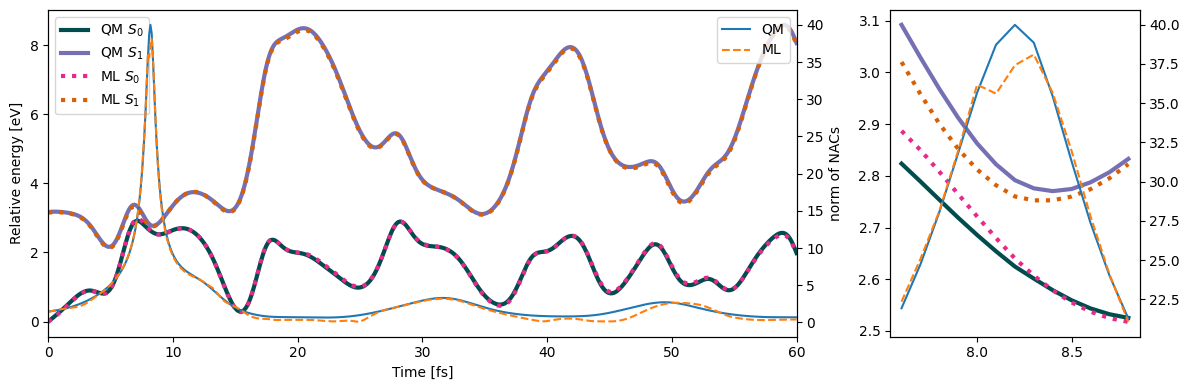

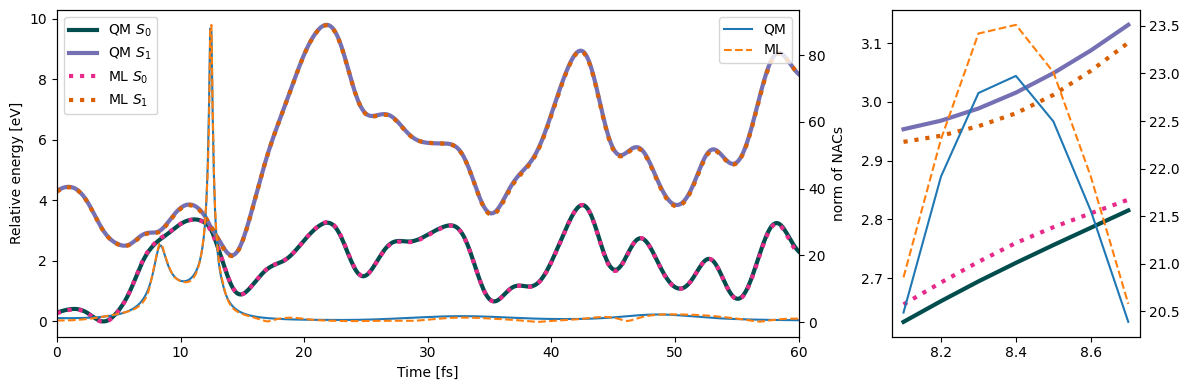

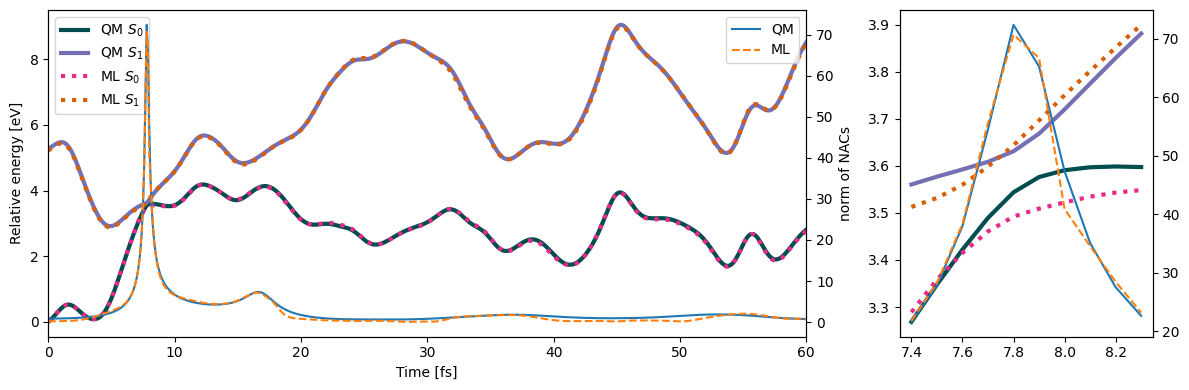

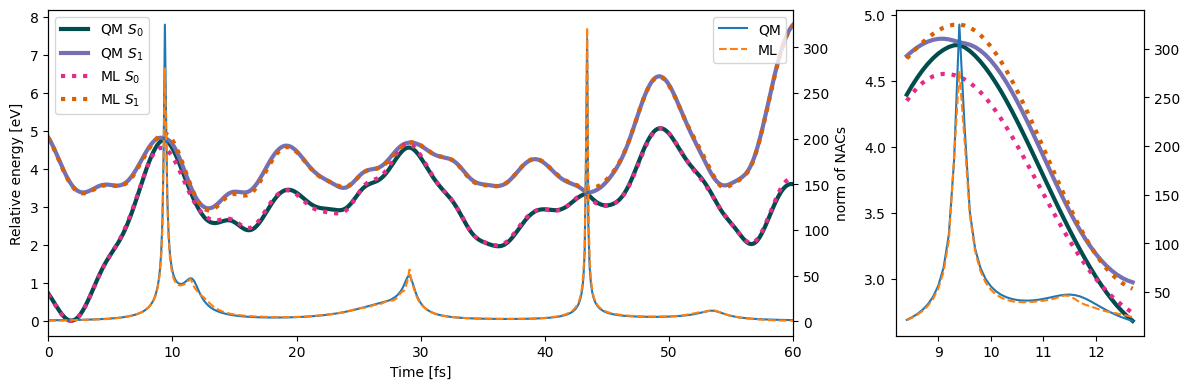

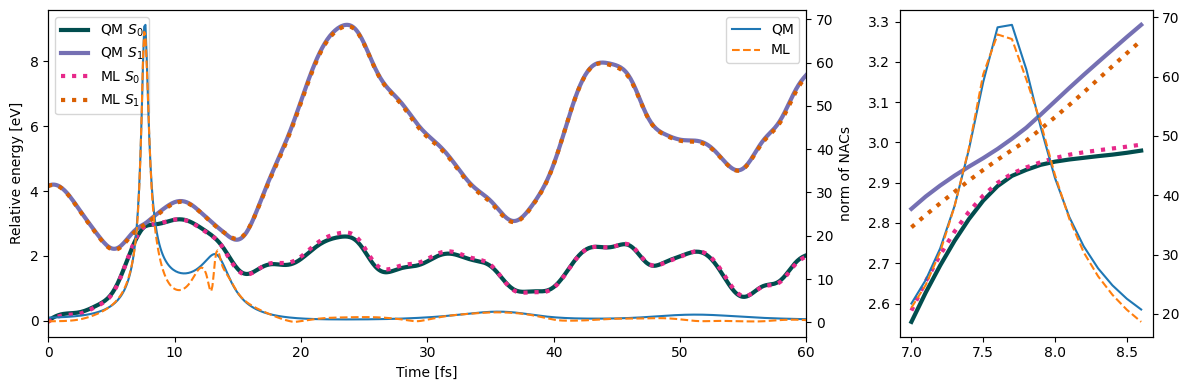

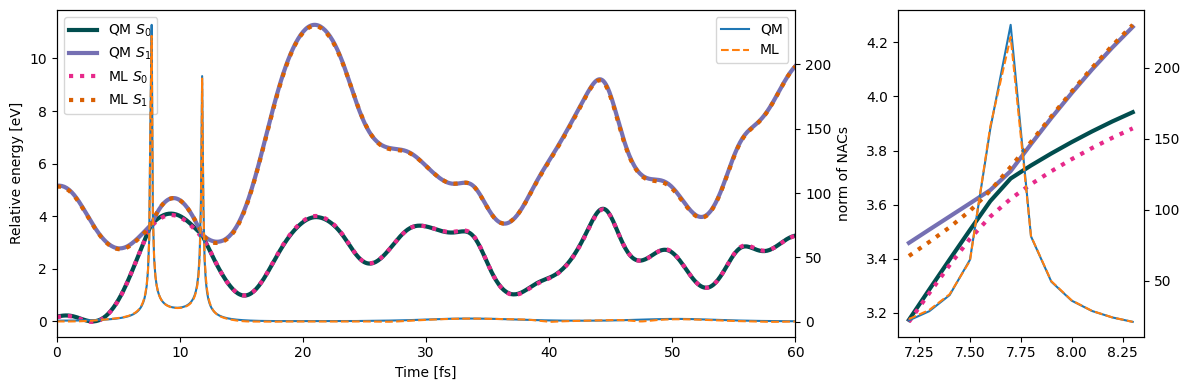

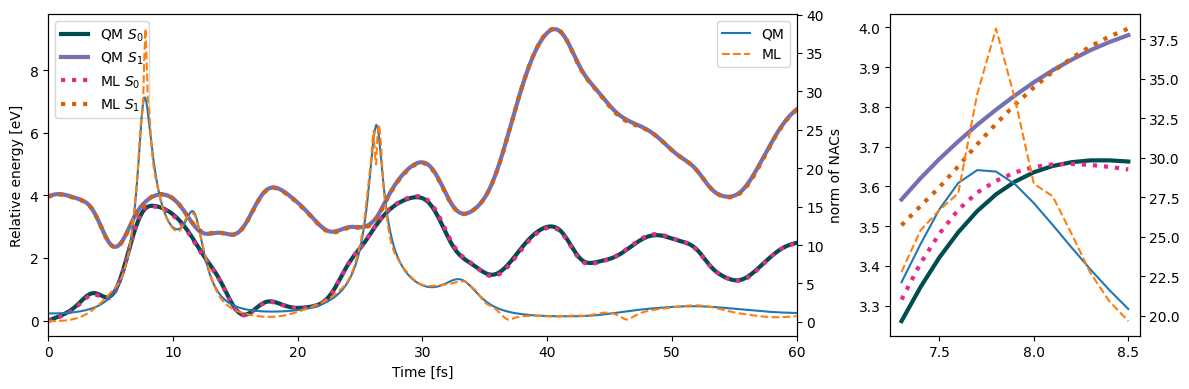

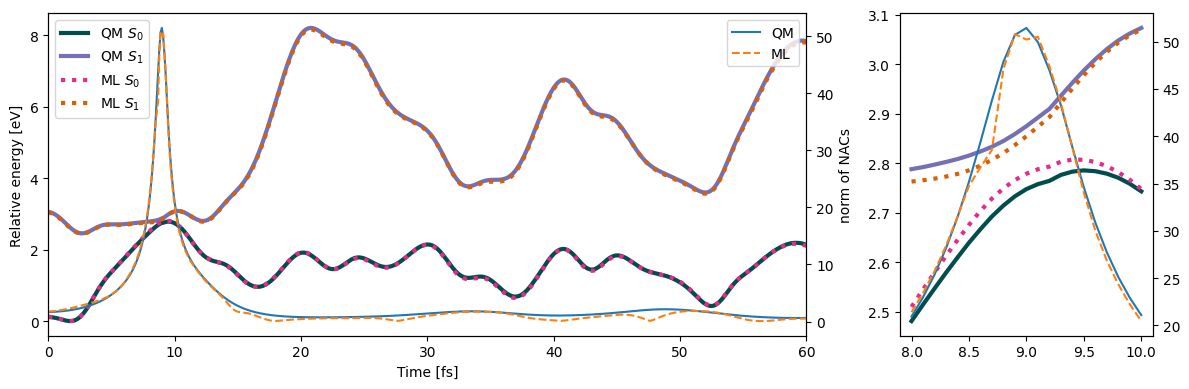

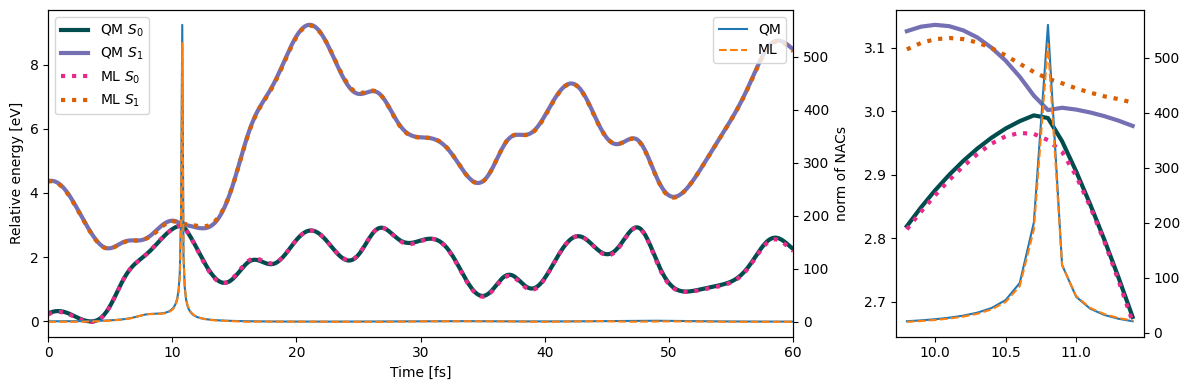

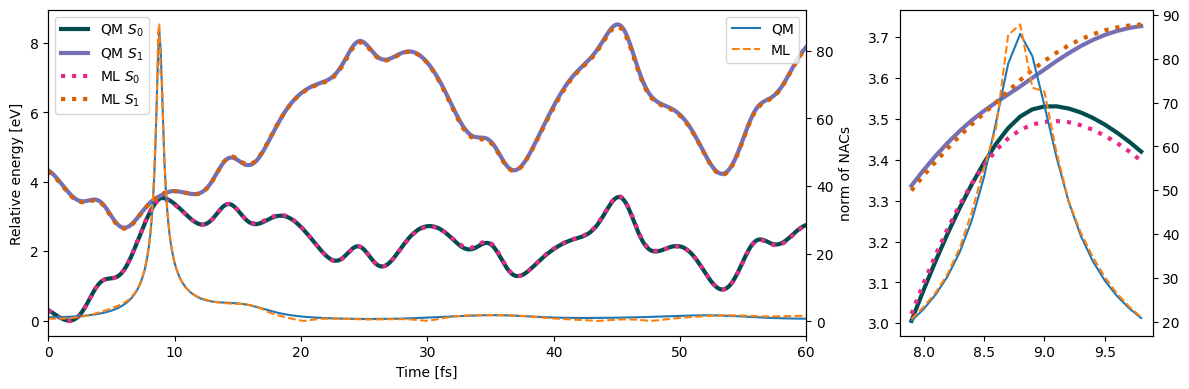

In [ ]:
Nsteps = 601
timestep = 0.1

from matplotlib.gridspec import GridSpec

for i in range(10):
    fig = plt.figure(figsize=(12, 4))
    gs = GridSpec(1, 2, width_ratios=[3, 1], figure=fig)

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    time = np.arange(0.0, Nsteps*timestep, timestep)

    e_min = min(ref_e0[i*Nsteps:i*Nsteps+Nsteps])
    ax1.plot(time, (ref_e0[i*Nsteps:i*Nsteps+Nsteps]-e_min)*ml.constants.Hartree2eV, lw=3, c=cdg, label=r"QM $S_0$")
    ax1.plot(time, (ref_e1[i*Nsteps:i*Nsteps+Nsteps]-e_min)*ml.constants.Hartree2eV, lw=3, c=cp, label=r"QM $S_1$")
    ax1.plot(time, (ml_e0_msani[i*Nsteps:i*Nsteps+Nsteps]-e_min)*ml.constants.Hartree2eV, ':', lw=3, c=cr, label=r"ML $S_0$")
    ax1.plot(time, (ml_e1_msani[i*Nsteps:i*Nsteps+Nsteps]-e_min)*ml.constants.Hartree2eV, ':', lw=3, c=co, label=r"ML $S_1$")

    ax1.set_ylabel("Relative energy [eV]")
    ax1.set_xlabel("Time [fs]")
    ax1.set_xlim([0, 60])
    ax1.legend(loc="best")

    ax1b = ax1.twinx()
    ax1b.plot(time, ref_nnacs[i*Nsteps:i*Nsteps+Nsteps], label="QM")
    ax1b.plot(time, ml_nnacs[i*Nsteps:i*Nsteps+Nsteps], '--', label="ML")
    ax1b.set_ylabel("norm of NACs")
    ax1b.legend(loc="upper right")

    nnacs_vals = np.array(ref_nnacs[i*Nsteps:i*Nsteps+Nsteps])
    mask = nnacs_vals > 20
    diff = np.diff(mask.astype(int))
    starts = np.where(diff == 1)[0] + 1
    ends   = np.where(diff == -1)[0] + 1

    if mask[0]:
        starts = np.insert(starts, 0, 0)
    if mask[-1]:
        ends = np.append(ends, len(mask))
    first_start, first_end = starts[0], ends[0]

    ax2.plot(time[first_start:first_end], (ref_e0[i*Nsteps:i*Nsteps+Nsteps][first_start:first_end]-e_min)*ml.constants.Hartree2eV, lw=3, c=cdg)
    ax2.plot(time[first_start:first_end], (ref_e1[i*Nsteps:i*Nsteps+Nsteps][first_start:first_end]-e_min)*ml.constants.Hartree2eV, lw=3, c=cp)
    ax2.plot(time[first_start:first_end], (ml_e0_msani[i*Nsteps:i*Nsteps+Nsteps][first_start:first_end]-e_min)*ml.constants.Hartree2eV, ':', lw=3, c=cr)
    ax2.plot(time[first_start:first_end], (ml_e1_msani[i*Nsteps:i*Nsteps+Nsteps][first_start:first_end]-e_min)*ml.constants.Hartree2eV, ':', lw=3, c=co)

    #ax2.set_xlim([0, 60])

    ax2b = ax2.twinx()
    ax2b.plot(time[first_start:first_end], np.array(ref_nnacs[i*Nsteps:i*Nsteps+Nsteps])[first_start:first_end], label="QM")
    ax2b.plot(time[first_start:first_end], np.array(ml_nnacs[i*Nsteps:i*Nsteps+Nsteps])[first_start:first_end], '--', label="ML")

    #save_fig(f'nacs_{i}')
    plt.show()


# 6. The analysis of ML models near CI seam

In [37]:
# Initial geometry and grid size
Emin = -230.720524839
grid_size = 11
dihedral_init = 62.96

In [38]:
mols = ml.data.molecular_database.load(filename=f'data/grid_PES_col.json', format='json')

dihedral = []; bond_lenght = []
bond_tr = np.linspace(-0.3, 0.12, grid_size)
bond_rot = np.linspace(0, 180, grid_size)

energies_s0 = np.zeros((grid_size,grid_size))
energies_s1 = np.zeros((grid_size,grid_size))

k = 0
for i in range(grid_size):
    dihedral.append(bond_rot[i]+dihedral_init)
    for j in range(grid_size):
        if i == 0:
            bond_lenght.append(np.sqrt(sum(((mols[k].xyz_coordinates[0] - mols[k].xyz_coordinates[5]))**2)))
        energies_s0[i,j] = (mols[k].electronic_states[0].energy - Emin) * ml.constants.Hartree2eV
        energies_s1[i,j] = (mols[k].electronic_states[1].energy - Emin) * ml.constants.Hartree2eV
        k += 1

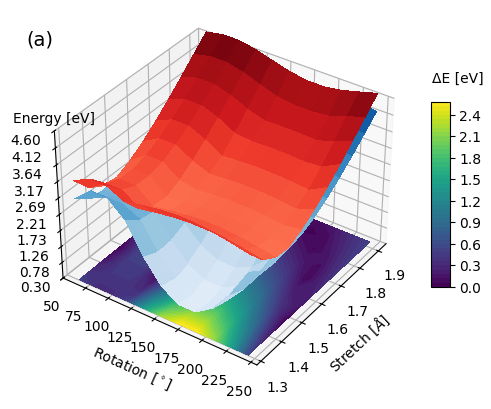

In [39]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.view_init(elev=35, azim=35, roll=0)

X, Y = np.meshgrid(bond_lenght, dihedral)

zmin = min(energies_s0.min(), energies_s1.min())-0.5
zmax = max(energies_s0.max(), energies_s1.max())
norm = plt.Normalize(vmin=zmin, vmax=zmax)

surf = ax.plot_surface(X, Y, energies_s0, cmap=cm.Blues, norm=norm, alpha=1, linewidth=0, antialiased=False)
surf = ax.plot_surface(X, Y, energies_s1, cmap=cm.Reds, norm=norm, alpha=1, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')

diff = energies_s1 - energies_s0
norm_diff = plt.Normalize(vmin=diff.min(), vmax=diff.max())
ground = ax.contourf(X, Y, diff, zdir='z', levels=50, offset=zmin, cmap='viridis', norm=norm_diff)

ax.set_xlabel(r'Stretch [$\AA$]')
ax.set_ylabel(r'Rotation [$^\circ$]')
ax.set_xlim(max(bond_lenght)+0.02, min(bond_lenght)-0.02)
ax.set_zlim(0.3, 4.6)

ax.text(1.3, 35, ax.get_zlim()[1]+2, '(a)', ha='center', va='bottom', fontsize=14)
ax.text(1.3, 45, ax.get_zlim()[1], 'Energy [eV]', ha='center', va='bottom')

cb = fig.colorbar(ground, shrink=0.5, aspect=10, pad=0.05)
ax.text(2.1, 290, ax.get_zlim()[1], 'ΔE [eV]', ha='center', va='bottom')

#save_fig('COL_PES', tight_layout=False)

plt.show()

In [ ]:
mols = ml.data.molecular_database.load(filename=f'data/grid_PES_msani.json', format='json')

dihedral = []; bond_lenght = []
bond_tr = np.linspace(-0.3, 0.12, grid_size)
bond_rot = np.linspace(0, 180, grid_size)

energies_s0 = np.zeros((grid_size,grid_size))
energies_s1 = np.zeros((grid_size,grid_size))

k = 0
for i in range(grid_size):
    dihedral.append(bond_rot[i]+dihedral_init)
    for j in range(grid_size):
        if i == 0:
            bond_lenght.append(np.sqrt(sum(((mols[k].xyz_coordinates[0] - mols[k].xyz_coordinates[5]))**2)))
        energies_s0[i,j] = (mols[k].electronic_states[0].energy - Emin) * ml.constants.Hartree2eV
        energies_s1[i,j] = (mols[k].electronic_states[1].energy - Emin) * ml.constants.Hartree2eV
        k += 1

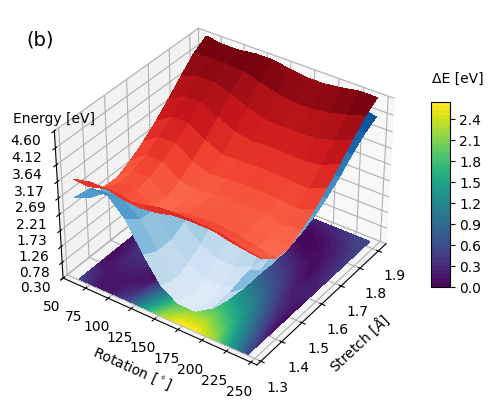

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.view_init(elev=35, azim=35, roll=0)

X, Y = np.meshgrid(bond_lenght, dihedral)

zmin = min(energies_s0.min(), energies_s1.min())-0.5
zmax = max(energies_s0.max(), energies_s1.max())
norm = plt.Normalize(vmin=zmin, vmax=zmax)

surf = ax.plot_surface(X, Y, energies_s0, cmap=cm.Blues, norm=norm, alpha=1, linewidth=0, antialiased=False)
surf = ax.plot_surface(X, Y, energies_s1, cmap=cm.Reds, norm=norm, alpha=1, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')

diff = energies_s1 - energies_s0
norm_diff = plt.Normalize(vmin=diff.min(), vmax=diff.max())
ground = ax.contourf(X, Y, diff, zdir='z', levels=50, offset=zmin, cmap='viridis', norm=norm_diff)

ax.set_xlabel(r'Stretch [$\AA$]')
ax.set_ylabel(r'Rotation [$^\circ$]')
ax.set_xlim(max(bond_lenght)+0.02, min(bond_lenght)-0.02)
ax.set_zlim(0.3, 4.6)

ax.text(1.3, 35, ax.get_zlim()[1]+2, '(b)', ha='center', va='bottom', fontsize=14)
ax.text(1.3, 45, ax.get_zlim()[1], 'Energy [eV]', ha='center', va='bottom')

cb = fig.colorbar(ground, shrink=0.5, aspect=10, pad=0.05)
ax.text(2.1, 290, ax.get_zlim()[1], 'ΔE [eV]', ha='center', va='bottom')

#save_fig('MSANI_PES', tight_layout=False)

plt.show()

#### Grid of geometries generated in Schmidt-orthogonalized $g$ and $h$ directions

Using CASSCF with the Lagrange--Newton algorithm (LN) in Columbus resulted in the most reliable MECI structure, characterized by $C-C=C-H$ dihedral angle of $\varphi \approx 63^\circ$. However, we used the penalty-constrained optimization (PCO, described in https://doi.org/10.1021/jp0761618) to obtain the MECI structures with both the ML model and CASSCF as reference. The average $\varphi$ values are reported in the table below along with the root mean square deviation (RMSD) for those three structures. When CASSCF and ML are used with the same algorithm, i.e. PCO, the RMSD is only 0.01794 Å demonstrating that the ML model can provide MECI structure with reasonable accuracy.

| Average $\varphi$ | [$^\circ$] | RMSD for MECI structures | [Å]   |
|:-----------------:|:----------:|:------------------------:|:-------:|
| LN(Col)           | 62.982     | PCO(Col) vs PCO(ML)      | 0.01794 |
| PCO(Col)          | 61.902     | LN(Col)  vs PCO(Col)     | 0.86932 |
| PCO(ML)           | 59.543     | LN(Col)  vs PCO(ML)      | 0.86976 |

Starting from the most reliable MECI structure obtained using the LN algorithm in Columbus (with CASSCF), a grid of geometries was generated along the Schmidt-orthogonalized $g$ and $h$ directions, calculated with either ML or CASSCF. Each geometry in the grid was labeled with ML or CASSCF to construct the PESs shown below. The ML-predicted $g$ and $h$ directions for the MECI structure produce different geometries, leading to distinct PESs (compare (a) to (c) and (b) to (d)). The branching space is therefore not well reproduced, as expected near the CI, where the accuracy slightly decreases and the generation of structures is sensitive to the direction of $g$ and $h$. In contrast, the CASSCF PESs are excellently reproduced by the ML model (compare (a) to (b) and (c) to (d)), which is a crucial component in accurately reproducing population dynamics noting that the trajectories rarely reach the CI seam.

ON(method) - method, which provided $g$ and $h$ to generate grid (orthonormal)

SP(method) - method, which was used to label the points (single point)


In [18]:
grid_size = 11
translate = np.arange(-(grid_size//2), grid_size//2+1) * 0.005

##### ON(Columbus) + SP(Columbus)

In [19]:
mols = ml.data.molecular_database.load(filename=f'data/ON-Col_SP-Col.json', format='json')

energies_s0 = np.zeros((grid_size,grid_size))
energies_s1 = np.zeros((grid_size,grid_size))

k = 0
for i in range(grid_size):
    for j in range(grid_size):
        energies_s0[i,j] = (mols[k].electronic_states[0].energy - Emin) * ml.constants.Hartree2eV
        energies_s1[i,j] = (mols[k].electronic_states[1].energy - Emin) * ml.constants.Hartree2eV
        k += 1

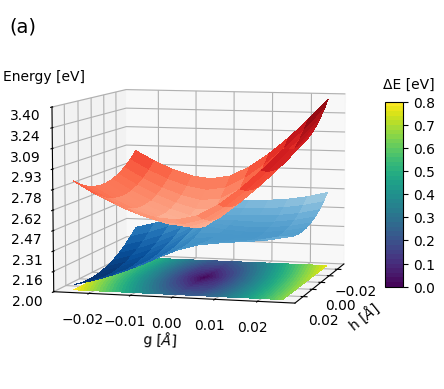

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.view_init(elev=7, azim=15, roll=0)

X, Y = np.meshgrid(translate, translate)

norm_s0 = plt.Normalize(vmin=energies_s0.min(), vmax=energies_s0.max()+0.3)
norm_s1 = plt.Normalize(vmin=energies_s1.min()-0.3, vmax=energies_s1.max())

surf = ax.plot_surface(X, Y, energies_s0, cmap=cm.Blues_r, norm=norm_s0, alpha=1, linewidth=0, antialiased=False)
surf = ax.plot_surface(X, Y, energies_s1, cmap=cm.Reds, norm=norm_s1, alpha=1, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')

diff = energies_s1 - energies_s0
norm_diff = plt.Normalize(vmin=diff.min(), vmax=diff.max())
ground = ax.contourf(X, Y, diff, levels=50, zdir='z', offset=2.0, cmap='viridis', norm=norm_diff)

ax.set_xlabel(r'h [$\AA$]')
ax.set_ylabel(r'g [$\AA$]')
for label, tick in zip(ax.get_xticklabels(), ax.get_xticks()):
    if round(abs(tick), 2) in [0.01, 0.03]:
        label.set_visible(False)

ax.text(0.03, -0.035, ax.get_zlim()[1]+0.5, '(a)', ha='center', va='bottom', fontsize=14)
ax.text(0.03, -0.03, ax.get_zlim()[1]+0.15, 'Energy [eV]', ha='center', va='bottom')

ax.set_zlim(2.0, 3.4)

cb = fig.colorbar(ground, shrink=0.5, aspect=10, pad=0)
ax.text(-0.02, 0.046, ax.get_zlim()[1]+0.05, 'ΔE [eV]', ha='center', va='bottom')

#save_fig('OPCol_SPCol', tight_layout=False)

plt.show()

##### ON(Columbus) + SP(MS-ANI + KRR)

In [23]:
mols = ml.data.molecular_database.load(filename=f'data/ON-Col_SP-ml.json', format='json')

energies_s0 = np.zeros((grid_size,grid_size))
energies_s1 = np.zeros((grid_size,grid_size))

k = 0
for i in range(grid_size):
    for j in range(grid_size):
        energies_s0[i,j] = (mols[k].electronic_states[0].energy - Emin) * ml.constants.Hartree2eV
        energies_s1[i,j] = (mols[k].electronic_states[1].energy - Emin) * ml.constants.Hartree2eV
        k += 1

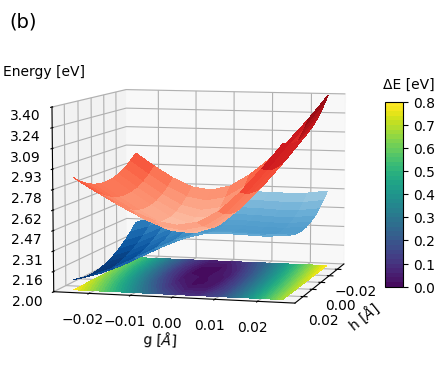

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.view_init(elev=7, azim=15, roll=0)

X, Y = np.meshgrid(translate, translate)

norm_s0 = plt.Normalize(vmin=energies_s0.min(), vmax=energies_s0.max()+0.3)
norm_s1 = plt.Normalize(vmin=energies_s1.min()-0.3, vmax=energies_s1.max())

surf = ax.plot_surface(X, Y, energies_s0, cmap=cm.Blues_r, norm=norm_s0, alpha=1, linewidth=0, antialiased=False)
surf = ax.plot_surface(X, Y, energies_s1, cmap=cm.Reds, norm=norm_s1, alpha=1, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')

diff = energies_s1 - energies_s0
norm_diff = plt.Normalize(vmin=diff.min(), vmax=diff.max())
ground = ax.contourf(X, Y, diff, levels=50, zdir='z', offset=2.0, cmap='viridis', norm=norm_diff)

ax.set_xlabel(r'h [$\AA$]')
ax.set_ylabel(r'g [$\AA$]')
for label, tick in zip(ax.get_xticklabels(), ax.get_xticks()):
    if round(abs(tick), 2) in [0.01, 0.03]:
        label.set_visible(False)

ax.text(0.03, -0.035, ax.get_zlim()[1]+0.5, '(b)', ha='center', va='bottom', fontsize=14)
ax.text(0.03, -0.03, ax.get_zlim()[1]+0.15, 'Energy [eV]', ha='center', va='bottom')

ax.set_zlim(2.0, 3.4)

cb = fig.colorbar(ground, shrink=0.5, aspect=10, pad=0)
ax.text(-0.02, 0.046, ax.get_zlim()[1]+0.05, 'ΔE [eV]', ha='center', va='bottom')

#save_fig('OPCol_SPml', tight_layout=False)

plt.show()

##### ON(MS-ANI + KRR) + SP(Columbus)

In [26]:
mols = ml.data.molecular_database.load(filename=f'data/ON-ml_SP-Col.json', format='json')

energies_s0 = np.zeros((grid_size,grid_size))
energies_s1 = np.zeros((grid_size,grid_size))

k = 0
for i in range(grid_size):
    for j in range(grid_size):
        energies_s0[i,j] = (mols[k].electronic_states[0].energy - Emin) * ml.constants.Hartree2eV
        energies_s1[i,j] = (mols[k].electronic_states[1].energy - Emin) * ml.constants.Hartree2eV
        k += 1

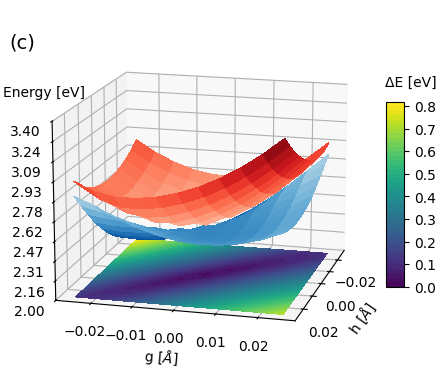

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.view_init(elev=15, azim=15, roll=0)

X, Y = np.meshgrid(translate, translate)

norm_s0 = plt.Normalize(vmin=energies_s0.min(), vmax=energies_s0.max()+0.3)
norm_s1 = plt.Normalize(vmin=energies_s1.min()-0.3, vmax=energies_s1.max())

surf = ax.plot_surface(X, Y, energies_s0, cmap=cm.Blues_r, norm=norm_s0, alpha=1, linewidth=0, antialiased=False)
surf = ax.plot_surface(X, Y, energies_s1, cmap=cm.Reds, norm=norm_s1, alpha=1, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')

diff = energies_s1 - energies_s0
norm_diff = plt.Normalize(vmin=diff.min(), vmax=diff.max())
ground = ax.contourf(X, Y, diff, levels=50, zdir='z', offset=2.0, cmap='viridis', norm=norm_diff)

ax.set_xlabel(r'h [$\AA$]')
ax.set_ylabel(r'g [$\AA$]')
for label, tick in zip(ax.get_xticklabels(), ax.get_xticks()):
    if round(abs(tick), 2) in [0.01, 0.03]:
        label.set_visible(False)

ax.text(0.03, -0.035, ax.get_zlim()[1]+0.5, '(c)', ha='center', va='bottom', fontsize=14)
ax.text(0.03, -0.03, ax.get_zlim()[1]+0.15, 'Energy [eV]', ha='center', va='bottom')

ax.set_zlim(2.0, 3.4)

cb = fig.colorbar(ground, shrink=0.5, aspect=10, pad=0)
ax.text(-0.02, 0.046, ax.get_zlim()[1]+0.05, 'ΔE [eV]', ha='center', va='bottom')

#save_fig('OPml_SPCol', tight_layout=False)

plt.show()

##### ON(Columbus) + SP(MS-ANI + KRR)

In [34]:
mols = ml.data.molecular_database.load(filename=f'data/ON-ml_SP-ml.json', format='json')

energies_s0 = np.zeros((grid_size,grid_size))
energies_s1 = np.zeros((grid_size,grid_size))

k = 0
for i in range(grid_size):
    for j in range(grid_size):
        energies_s0[i,j] = (mols[k].electronic_states[0].energy - Emin) * ml.constants.Hartree2eV
        energies_s1[i,j] = (mols[k].electronic_states[1].energy - Emin) * ml.constants.Hartree2eV
        k += 1

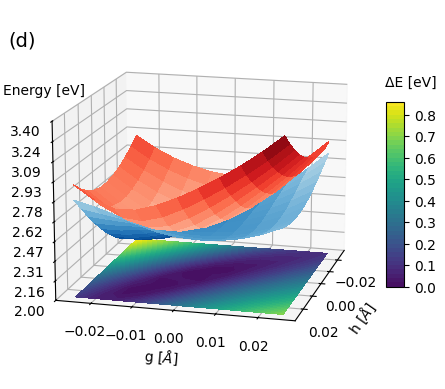

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.view_init(elev=15, azim=15, roll=0)

X, Y = np.meshgrid(translate, translate)

norm_s0 = plt.Normalize(vmin=energies_s0.min(), vmax=energies_s0.max()+0.3)
norm_s1 = plt.Normalize(vmin=energies_s1.min()-0.3, vmax=energies_s1.max())

surf = ax.plot_surface(X, Y, energies_s0, cmap=cm.Blues_r, norm=norm_s0, alpha=1, linewidth=0, antialiased=False)
surf = ax.plot_surface(X, Y, energies_s1, cmap=cm.Reds, norm=norm_s1, alpha=1, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')

diff = energies_s1 - energies_s0
norm_diff = plt.Normalize(vmin=diff.min(), vmax=diff.max())
ground = ax.contourf(X, Y, abs(diff), levels=50, zdir='z', offset=2.0, cmap='viridis', norm=norm_diff)

ax.set_xlabel(r'h [$\AA$]')
ax.set_ylabel(r'g [$\AA$]')
for label, tick in zip(ax.get_xticklabels(), ax.get_xticks()):
    if round(abs(tick), 2) in [0.01, 0.03]:
        label.set_visible(False)

ax.text(0.03, -0.035, ax.get_zlim()[1]+0.5, '(d)', ha='center', va='bottom', fontsize=14)
ax.text(0.03, -0.03, ax.get_zlim()[1]+0.15, 'Energy [eV]', ha='center', va='bottom')

ax.set_zlim(2.0, 3.4)

cb = fig.colorbar(ground, shrink=0.5, aspect=10, pad=0)
ax.text(-0.02, 0.046, ax.get_zlim()[1]+0.05, 'ΔE [eV]', ha='center', va='bottom')

#save_fig('OPml_SPml', tight_layout=False)

plt.show()

# 7. Population for CH<sub>2</sub>NH<sub>2</sub><sup>+</sup>

In [ ]:
pop_cnh4p = {'data/pop_COLE_COLNAC_63_CNH4p.txt': 63,
       'data/pop_MLE_MLNAC_63_CNH4p.txt': 63,
       'data/pop_MLE_LZBL_63_CNH4p.txt': 63,
       }
pop_cnh4p_names = list(pop_cnh4p.keys())

data_cnh4p_pop = {'time': []}
for i, name in enumerate(pop_cnh4p.keys()):
    data_cnh4p_pop[name] = {'S0': [], 'S1': [], 'S2': [], 'S0pe': [], 'S0me': [], 'S1pe': [], 'S1me': [], 'S2pe': [], 'S2me': []}
    with open(name, 'r') as ff:
        j = 0
        for line in ff.read().splitlines():
            values = list(map(float, line.split()))
            if i == 0:
                data_cnh4p_pop['time'].append(values[0])
            data_cnh4p_pop[name]['S0'].append(values[1])
            data_cnh4p_pop[name]['S1'].append(values[2])
            data_cnh4p_pop[name]['S2'].append(values[3])
            err = mean_confidence_interval(data_cnh4p_pop[name]['S0'][j], pop_cnh4p[name])
            data_cnh4p_pop[name]['S0pe'].append(data_cnh4p_pop[name]['S0'][j]+err)
            data_cnh4p_pop[name]['S0me'].append(data_cnh4p_pop[name]['S0'][j]-err)
            err = mean_confidence_interval(data_cnh4p_pop[name]['S1'][j], pop_cnh4p[name])
            data_cnh4p_pop[name]['S1pe'].append(data_cnh4p_pop[name]['S1'][j]+err)
            data_cnh4p_pop[name]['S1me'].append(data_cnh4p_pop[name]['S1'][j]-err)
            err = mean_confidence_interval(data_cnh4p_pop[name]['S2'][j], pop_cnh4p[name])
            data_cnh4p_pop[name]['S2pe'].append(data_cnh4p_pop[name]['S2'][j]+err)
            data_cnh4p_pop[name]['S2me'].append(data_cnh4p_pop[name]['S2'][j]-err)
            j += 1

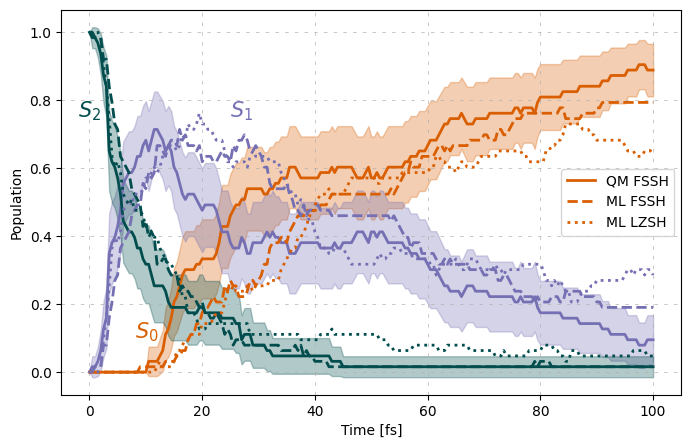

In [ ]:
lines = ['-', '--', ':']
labels = ['QM FSSH', 'ML FSSH', 'ML LZSH']
states = ['S1', 'S2']
colors = [cp, cdg]

fig, ax = plt.subplots(1, figsize=(8, 5))

for i, name in enumerate(pop_cnh4p_names):
    ax.plot(data_cnh4p_pop['time'], data_cnh4p_pop[name]['S0'], lines[i], c=co, lw=2, label=labels[i])
    if name == 'data/pop_COLE_COLNAC_63_CNH4p.txt':
        ax.fill_between(data_cnh4p_pop['time'], data_cnh4p_pop[name]['S0pe'], data_cnh4p_pop[name]['S0me'], color=co, alpha=0.3)
    for j in range(2):
        ax.plot(data_cnh4p_pop['time'], data_cnh4p_pop[name][states[j]], lines[i], c=colors[j], lw=2)
        if name == 'data/pop_COLE_COLNAC_63_CNH4p.txt':
            ax.fill_between(data_cnh4p_pop['time'], data_cnh4p_pop[name][f'{states[j]}pe'], data_cnh4p_pop[name][f'{states[j]}me'], color=colors[j], alpha=0.3)

ax.set_ylabel('Population')
ax.set_xlabel('Time [fs]')
ax.grid(linestyle = '--', dashes=(5, 9), linewidth = 0.5)
ax.text(8, 0.1, '$S_0$', c=co, fontsize=15)
ax.text(25, 0.75, '$S_1$', c=cp, fontsize=15)
ax.text(-2, 0.75, '$S_2$', c=cdg, fontsize=15)

ax.legend(ncols=1)

#save_fig('populations_cnh4p', tight_layout=False)
plt.show()


# 7. Tiny plots for diagram

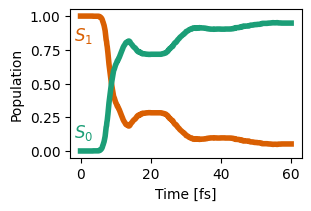

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2), layout="compressed")

ax.set_xlabel('Time [fs]')
ax.set_ylabel('Population')
ax.plot(data_pop['time'], data_pop[pop_names[4]]['S1'], c=co, lw=4)
ax.plot(data_pop['time'], data_pop[pop_names[4]]['S0'], c=cg, lw=4)
ax.text(-2, 0.1, r'$S_0$', weight='bold', c=cg, fontsize=12)
ax.text(-2, 0.82, r'$S_1$', weight='bold', c=co, fontsize=12)

#save_fig('pnew', tight_layout=False)
plt.show()

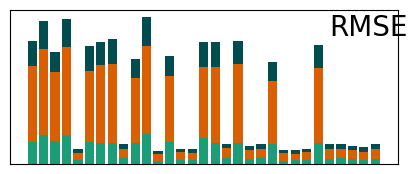

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2))

bottom = np.zeros(31)
colors = [cg, co, cdg]

i = 0
for d, d_count in benchmark_data_casscf.items():
    if 'RMSE' in d:
        p = ax.bar(benchmark_data_casscf['Descriptor'], d_count, 0.8, color=colors[i], label=d, bottom=bottom)
        bottom += d_count
        i += 1
ax.text(26, 5.7, r'RMSE', fontsize=20)
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
#save_fig('rmse')
plt.show()

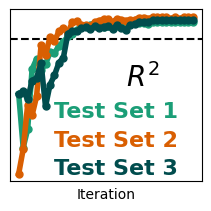

In [13]:
df2 = pd.read_csv('data/phasecorrection_opthyper.csv')

fig, ax = plt.subplots(1, 1, figsize=(2, 2), layout="compressed")

ax.set_xlabel("Iteration")

ax.axhline(y=.9, c="black", linestyle='--')
l3, = ax.plot(df2['iteration'], df2['R2_1'], 'o-', lw=4, label="Test set 1", c=cg, markersize=5)
l4, = ax.plot(df2['iteration'], df2['R2_2'], 'o-', lw=4, label="Test set 2", c=co, markersize=5)
l5, = ax.plot(df2['iteration'], df2['R2_3'], 'o-', lw=4, label="Test set 3", c=cdg, markersize=5)
ax.text(25, 0.7, '$R^2$', fontsize=20)
ax.text(9, 0.57, r'Test Set 1', weight='bold', c=cg, fontsize=16)
ax.text(9, 0.45, r'Test Set 2', weight='bold', c=co, fontsize=16)
ax.text(9, 0.33, r'Test Set 3', weight='bold', c=cdg, fontsize=16)

ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', left=False, labelleft=False)

#save_fig('r2')
plt.show()